In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pymorphy2
import urllib.request
import json   
import requests

from pymorphy2.tokenizers import simple_word_tokenize
from pymorphy2.shapes import is_punctuation
from collections import Counter
from stop_words import get_stop_words
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.externals import joblib

In [2]:
df_origin = pd.read_csv("../data/itil-tickets-6.csv", sep=',')
# df = pd.read_clipboard()
# df.to_csv('../data/itil-tickets-6.csv', index=False)
df_origin = df_origin.dropna()
df = df_origin.copy()

df['specialist'].replace(['Руководители службы Service Desk', 'Шкурупий Денис'], 'Манюхин Андрей', inplace=True)
df['specialist'].replace('Кухарчук Дмитрий', 'Сергиевич Юрий', inplace=True)
df['specialist'].replace('Талаева Вера', 'Кропис Юлия', inplace=True)
df['specialist'].replace('Быков Вадим', 'Полегошко Андрей', inplace=True)

display(df.sample(n=5).head())
display(df.shape)

,route,specialist,title,category,analytics1,analytics2,analytics3,user
250,зо,Полегошко Андрей,Требуется установить на комп. программы: 1)ком...,Software::Specialized Soft,СМАРТОН,Программное обеспечение,Поддержка инфраструктуры,Манюхин Андрей
14730,зи,Швец Богдан,акция продукты Старый Токио,Выгрузка данных,Маркетинг,1С УТ 11,Поддержка УТ11,Талаева Вера
12095,зо,Сергиевич Юрий,Перевести задание на перевозку 1692 от 17.02 ...,Изменение данных,Отдел разработки 1С,1С УТ 11,Поддержка УТ11,Талаева Вера
9882,зо,Кропис Юлия,Корректировка реализации 134535,Консультация,Оптовый отдел,1С УТ 11,Поддержка УТ11,Ржеутская Татьяна
13466,зо,Кропис Юлия,На сайте в кабинете пользователя не отображает...,Неизвестная проблема,Маркетинг,1С УТ 11,Поддержка УТ11,Басалык Константин


(13781, 8)

In [3]:
def show_distr(df, name, quantile=1):
    df_ = df.copy()
    grouped = df_[name].value_counts()
    grouped = grouped[grouped>=grouped.quantile(q=quantile)]
#     display(grouped)

    fig = plt.figure(figsize=(12, 6))
    ax = grouped.sort_values(ascending=True).plot.barh(ylim=0, title=name)
#     plt.savefig('%s.png'%(name))
#     ax.axhline(y='Email')
#     plt.plot((0, 'Email'), (3000, 'Email'), 'k-')
    plt.show()
    
def get_top(df, name, quantile=1):
    grouped = df[name].value_counts()
    grouped = grouped[grouped>=grouped.quantile(q=quantile)]
    return grouped.index.tolist()

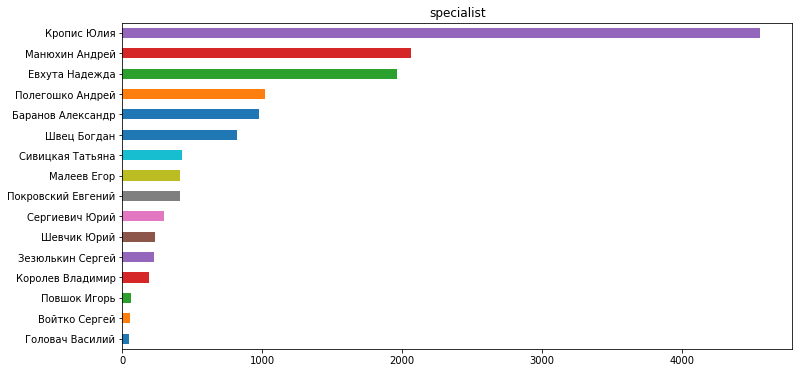

In [4]:
show_distr(df, 'specialist', 0.25)

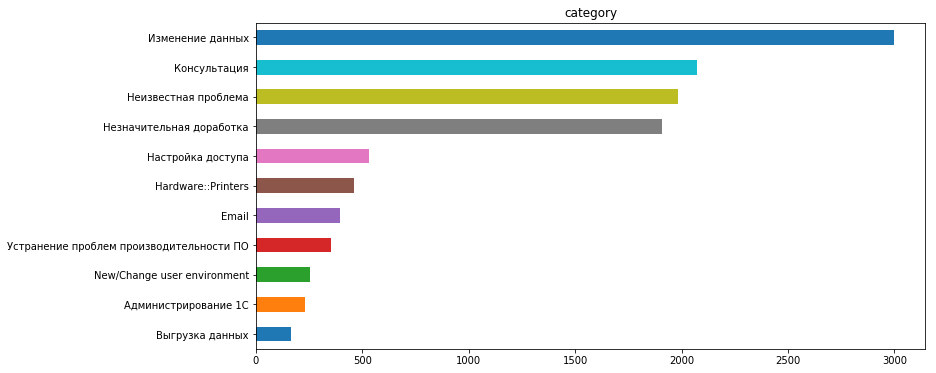

In [5]:
show_distr(df, 'category', 0.85)

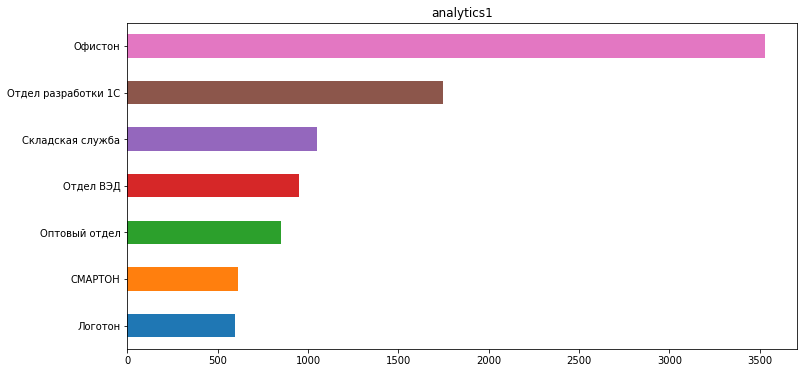

In [6]:
show_distr(df, 'analytics1', 0.85)

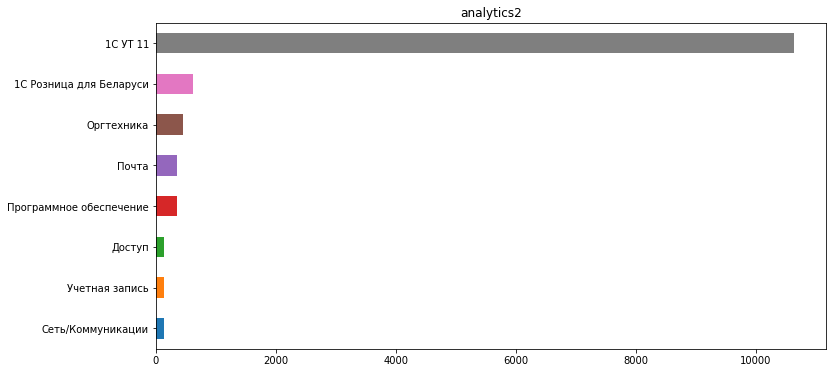

In [7]:
show_distr(df, 'analytics2', 0.85)

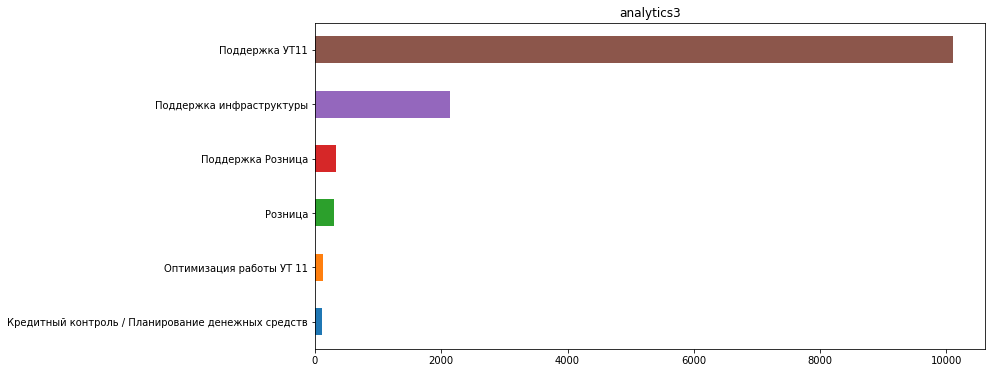

In [8]:
show_distr(df, 'analytics3', 0.85)

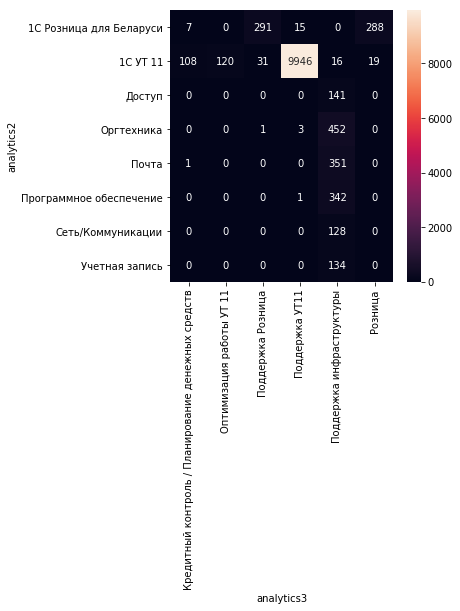

In [9]:
df_analytics = df_origin[['analytics2', 'analytics3']].copy()
analytics2_top = get_top(df_analytics, 'analytics2', 0.85)
analytics3_top = get_top(df_analytics, 'analytics3', 0.85)

df_analytics = df_analytics[df_analytics['analytics2'].isin(analytics2_top) & df_analytics['analytics3'].isin(analytics3_top)]

df_analytics_unst = df_analytics.groupby('analytics2')['analytics3'].value_counts().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df_analytics_unst, annot=True, fmt="g")
plt.show()

### Elastic Search Baseline

### Preprocessing

In [10]:
# select top 85% specialists
specialist_top = get_top(df, 'specialist', 0.25)
df = df[df['specialist'].isin(specialist_top)]    

In [11]:
# specialist to category
col = ['specialist', 'title']
df = df[col]
df = df[pd.notnull(df['title'])]

df['category_id'] = df['specialist'].factorize()[0]
category_id_df = df[['specialist', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'specialist']].values)
df.head()

,specialist,title,category_id
1,Манюхин Андрей,проверка работы,0
3,Манюхин Андрей,Test!,0
4,Манюхин Андрей,Проверка работы itil,0
5,Манюхин Андрей,Test md,0
7,Манюхин Андрей,Проверка работы ITIL,0


In [12]:
def replace_by_re(s, pattern, repl):
    return re.sub(pattern, repl, s)

df['title'] = df['title'].apply(replace_by_re, args=('1[CСcс]', "1С"))
df['title'] = df['title'].apply(replace_by_re, args=('FW:\s+', ""))
df['title'] = df['title'].apply(replace_by_re, args=('RE:\s+', ""))
df['title'] = df['title'].apply(replace_by_re, args=('(\d{2}[\.\\\/]){2}(\d{2})+', "дата"))
# df['title'] = df['title'].apply(replace_by_re, args=("[\:\#\№%\!\d\-\'\.]", ""))
# df['title'] = df['title'].apply(replace_by_re, args=('\"', ""))

df = df[df['title']!='']

df['title'].loc[:10]

1          проверка работы
3                    Test!
4     Проверка работы itil
5                  Test md
7     Проверка работы ITIL
9                 проверка
10                    Test
Name: title, dtype: object

In [13]:
morph = pymorphy2.MorphAnalyzer()
cnt = Counter()
stop_words = get_stop_words('russian')

def lemmatize(s):
    l = [morph.parse(w)[0].normal_form for w in simple_word_tokenize(s) if not is_punctuation(w)]
    l = [w for w in l if w not in stop_words]
    
    cnt.update(l)
    
    return " ".join(l)

df['title'] = df['title'].apply(lemmatize)

df['title'].loc[:10]

1          проверка работа
3                     test
4     проверка работа itil
5                  test md
7     проверка работа itil
9                 проверка
10                    test
Name: title, dtype: object

In [14]:
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df['title'], df['specialist'], df.index, test_size=0.2, random_state=42)

### Transform

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))

features_train = tfidf.fit_transform(X_train).toarray()
labels_train = df.loc[indices_train.values].category_id

features_test = tfidf.transform(X_test).toarray()
labels_test = df.loc[indices_test.values].category_id

In [16]:
print(tfidf.get_feature_names()[:100])

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1с', '1с бухгалтерия', '1с зуп', '1с невозможно', '1с предприятие', '1с розница', '1с сайт', '1с специалист', '1с ут', '1срозница', '1срозница закупка', '1срозница пересортица', '1срозница продажа', '1срозница склад', '20', '200', '2016', '2016г', '2017', '2018', '21', '22', '24', '25', '26', '27', '28', '29', '30', '3055', '31', '3м', '3м шаг', '50', '59', '605', '608', 'abc', 'adobe', 'belkanton', 'by', 'cleanton', 'com', 'communicator', 'dbf', 'dev', 'edi', 'edi topby', 'edy', 'elastalert', 'elastalert ой', 'excel', 'f6', 'fi', 'fw', 'fwd', 'hp', 'hp laserjet', 'http', 'https', 'https www', 'id', 'info', 'ip', 'it', 'itil', 'laserjet', 'logiston', 'logoton', 'logoton by', 'mail', 'megacount', 'microsoft', 'microsoft office', 'mightycall', 'missing', 'missing value', 'new', 'office', 'officelife']


### Model Search

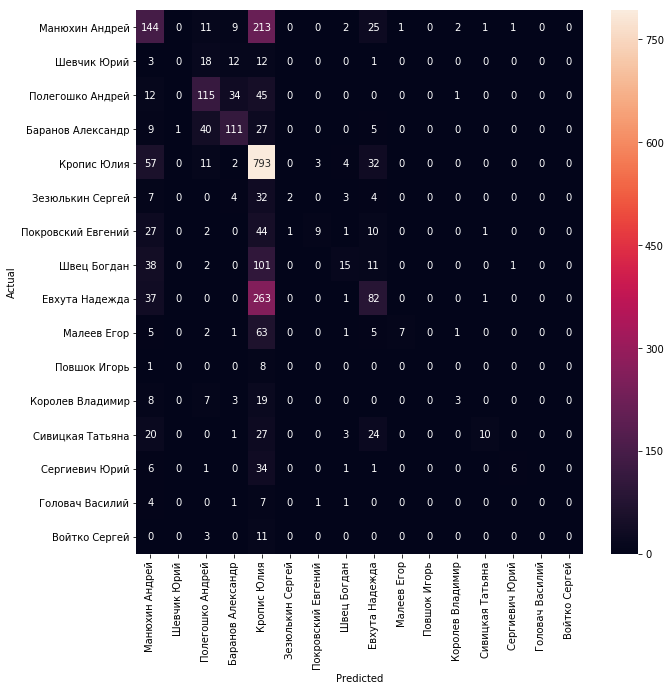

In [17]:
model = MultinomialNB()
model.fit(features_train, labels_train)
labels_pred = model.predict(features_test)

conf_mat = metrics.confusion_matrix(labels_test, labels_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='g', xticklabels=category_id_df.specialist.values, yticklabels=category_id_df.specialist.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# plt.savefig('heatmap.png')

In [18]:
category_id_df['specialist'].values

array(['Манюхин Андрей', 'Шевчик Юрий', 'Полегошко Андрей',
       'Баранов Александр', 'Кропис Юлия', 'Зезюлькин Сергей',
       'Покровский Евгений', 'Швец Богдан', 'Евхута Надежда',
       'Малеев Егор', 'Повшок Игорь', 'Королев Владимир',
       'Сивицкая Татьяна', 'Сергиевич Юрий', 'Головач Василий',
       'Войтко Сергей'], dtype=object)

In [19]:
#df['specialist'].unique()
print(metrics.classification_report(labels_test, labels_pred, target_names=category_id_df['specialist'].values))

                    precision    recall  f1-score   support

    Манюхин Андрей       0.38      0.35      0.37       409
       Шевчик Юрий       0.00      0.00      0.00        46
  Полегошко Андрей       0.54      0.56      0.55       207
 Баранов Александр       0.62      0.58      0.60       193
       Кропис Юлия       0.47      0.88      0.61       902
  Зезюлькин Сергей       0.67      0.04      0.07        52
Покровский Евгений       0.69      0.09      0.17        95
       Швец Богдан       0.47      0.09      0.15       168
    Евхута Надежда       0.41      0.21      0.28       384
       Малеев Егор       0.88      0.08      0.15        85
      Повшок Игорь       0.00      0.00      0.00         9
  Королев Владимир       0.43      0.07      0.13        40
  Сивицкая Татьяна       0.77      0.12      0.20        85
    Сергиевич Юрий       0.75      0.12      0.21        49
   Головач Василий       0.00      0.00      0.00        14
     Войтко Сергей       0.00      0.00

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
features = tfidf.fit_transform(df['title']).toarray()
labels = df.category_id

df_ngrams = pd.DataFrame(columns=['specialist', 'unigrams', 'bigrams'])

model.fit(features, labels)
N = 2
for user, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]

    df_ngrams = df_ngrams.append({
        'specialist':user,
        'unigrams':', '.join(unigrams),
        'bigrams':', '.join(bigrams)
    }, ignore_index=True)

#     print("# '{}':".format(user))
#     print("  . Top unigrams: {}".format(', '.join(unigrams)))
#     print("  . Top bigrams: {}".format(', '.join(bigrams)))

df_ngrams

,specialist,unigrams,bigrams
0,Баранов Александр,"переадресация, доступ","работать телефон, переадресация почта"
1,Войтко Сергей,"сотрудник, новый","новый сотрудник, доступ 1с"
2,Головач Василий,"сайт, белкантон","сайт белкантон, сайт бкг"
3,Евхута Надежда,"подарок, база","орг вопрос, розница орг"
4,Зезюлькин Сергей,"1с, база","копия база, missing value"
5,Королев Владимир,"доступ, новый","учётный запись, новый сотрудник"
6,Кропис Юлия,"реализация, база","висеть база, зона доставка"
7,Малеев Егор,"себестоимость, срочно","1с ут, гтд москва"
8,Манюхин Андрей,"заказ, отчёт","печатный форма, заказ клиент"
9,Повшок Игорь,"сайт, офисмама","сайт офистон, личный кабинет"


# doc2vec

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess

In [ ]:
def tag_docs(docs, col, label): 
    tagged = docs.apply(lambda r: TaggedDocument(words=simple_preprocess(r[col]), tags=[r[label]]),  axis=1) 
    return tagged

def train_doc2vec_model(tagged_docs): 
    sents = tagged_docs.values
    doc2vec_model = Doc2Vec(sents, epochs=20, dm=1) #size=size, window=window, 
    return doc2vec_model

def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values 
    targets, regressors =  zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
train_tagged = tag_docs(train_data, 'title', 'specialist')
test_tagged = tag_docs(test_data, 'title', 'specialist')
model = train_doc2vec_model(train_tagged)

In [ ]:
y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)
logreg = LogisticRegression()
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=df['specialist'].unique()))